In [ ]:
# Randomforest 로 피쳐중요도 확인

from sklearn.ensemble import RandomForestClassifier

features = train.columns[1:-1]
train_x = train[features]
train_y = train['Outcome']

RF_model = RandomForestClassifier(random_state = 42)
RF_model.fit(train_x,train_y)
importances = RF_model.feature_importances_
feature_names = RF_model.feature_names_in_
plt.figure(figsize=(12,4))
sns.barplot(x=feature_names, y= importances)
plt.show()


```
importances = RF_model.feature_importances_
feature_names = RF_model.feature_names_in_
이라는 속성이용해서 작성
```

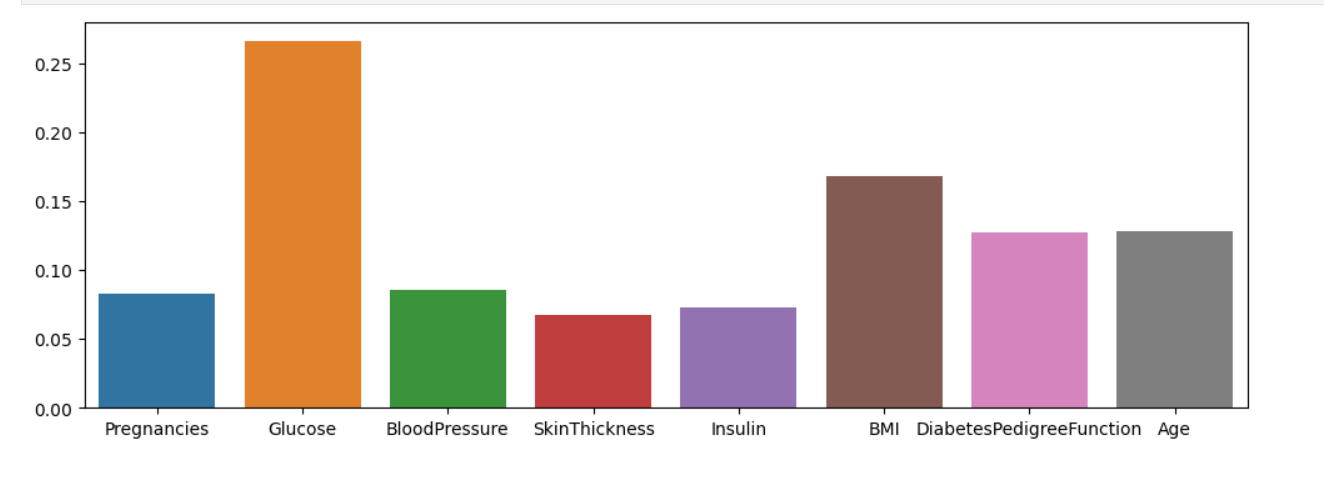

In [ ]:
# LogisticRegression 으로 피쳐중요도 확인

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

features = list(train.columns[1:-1])
train_x = train[features]
train_y = train['Outcome']

scaler = StandardScaler()
train_scaled_x = train_x.copy()
train_scaled_x[features] = scaler.fit_transform(train_x)

LR_model = LogisticRegression(random_state = 42, max_iter=2000)
LR_model.fit(train_scaled_x,train_y)
importances = list(np.abs(LR_model.coef_[0]))
feature_names = features

display(importances)
display(feature_names)
plt.figure(figsize=(12,4))
sns.barplot(x=feature_names, y= importances)
plt.show()

